### Regressions incorporating same session and previous session regressions

1/ Across all sessions
2/ Separtately for each wave 
3/ From session to session 

In [240]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os
print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore as zscore_sc
import bambi as bmb
import arviz as az
import bammm_local as mm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product, combinations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]
trait_factor_names_short = ["TF1", "TF2",  "TF3",]



mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Risk',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'Avoidance',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'ThreatPerception',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 
           }

vars = ["Cases", "ThreatPerception", "Risk", "Worry", "Avoidance", "InforSeek"]
#vars = [ "InforSeek","Avoidance", "Worry", "Risk", "ThreatPerception", "Cases" ]

#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception", "Worry", "AvoidAnx", "Deaths", "Cases"]


#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception",  "Deaths"]

df=df.rename(columns=mapdict)
dfall = df.copy()

df = df.loc[:,vars+["PROLIFICID","session"]]#.set_index("PROLIFICID")
# Discretize the numeric vector
bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
df["wave"] = pd.cut(df["session"], bins=bins, labels=labels, right=False, include_lowest=True)

# zscore each variable by session (for regressions)
for v in vars: 
    for s in df.session.unique(): 
      df.loc[df["session"]==s,v] = zscore_sc(np.array(df.loc[df["session"]==s,v]), nan_policy="omit")
    


def demultindex(df):
    df.columns = [ x+"_"+str(y) for x,y in df.columns ]
    return df

# Trait scores in a separate df
df_id = dfall.loc[:,["PROLIFICID"]+trait_factor_names_short].groupby(by="PROLIFICID").mean()

tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)

/data/drive/postdoc/Project4_covid


In [241]:
win=1


for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    regdf = pd.DataFrame()
    for s in np.arange(win+1,21):

        #tdf.loc[:,(dv,[1,2])]
        x_dv = demultindex(tdf.loc[:,(dv,np.arange(s-win,s+1))])
        x_dv = x_dv.rename(columns=dict(zip(x_dv.columns, [dv+"_lag"+str(x) for x in np.arange(win,-1, -1)])))

        x_dv["session"] = s
        x_dv["sess_str"] = "sess"+str(s)
        regdf = pd.concat([regdf, x_dv], axis=0)

    if dvidx == 0:
        fitdf = regdf
    else:
        fitdf = pd.merge(fitdf, regdf,  on=["PROLIFICID", "session"])

bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
fitdf["wave"] = pd.cut(fitdf["session"], bins=bins, labels=labels, right=False, include_lowest=True)

### Single model across all sessions

In [242]:
load_overall = 1
def determine_lag_status(text):
    if 'lag0' in text:
        return 'lag0'
    elif 'lag1' in text:
        return 'lag1'
    else:
        return 'na'

if load_overall==0:
    ddf = pd.DataFrame()
    fitdf2=fitdf.dropna().join(df_id).reset_index()
    for dvidx, dv in enumerate(vars):

        ### Fit lag1 model first, record residuls ###
        dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")]) for tf in ["TF1", "TF2", "TF3"] ]
        
        eq = mm.generate_equation(dv+"_lag0",  ["session"]+dvs, [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])

        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["DF"] = res.df_resid
        edf["tval"] = res.tvalues
        edf["dv"] = dv 
        edf["p"] = round(res.pvalues, 4)
        edf["eff_raw"] = edf.index
        edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
        edf["eff_time"] = "lag1"
        edf["indiff"] = edf.index.str.split(":").str[1]
        edf["iv"] = edf.index.str.split("_").str[0]

        fitdf2[dv+"_lag0_resid"] = res.resid
        ddf = pd.concat([ddf, edf.reset_index()])


        ### Fot contemporaneous model ###
        dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag0")]) for tf in ["TF1", "TF2", "TF3"] ]
        dvs = [i for i in dvs if dv+"_lag0" not in i]

        eq = mm.generate_equation(dv+"_lag0_resid",  ["session"]+dvs, [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])

        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["p"] = round(res.pvalues, 4)
        edf["eff_raw"] = edf.index
        edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
        edf["eff_time"] = "lag0"
        edf["indiff"] = edf.index.str.split(":").str[1]
        edf["iv"] = edf.index.str.split("_").str[0]

        ddf = pd.concat([ddf, edf.reset_index()])
        


    ddf.to_csv(os.path.join(root_dir, 'output', 'working_data', 'step_full_model.csv'))
elif load_overall==1:
    ddf = pd.read_csv(os.path.join(root_dir, 'output', 'working_data', 'step_full_model.csv'))


In [243]:
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

var_to_id


{'Cases': 0,
 'ThreatPerception': 1,
 'Risk': 2,
 'Worry': 3,
 'Avoidance': 4,
 'InforSeek': 5}

In [246]:
ddf.loc[ (ddf["indiff"] =="TF3") & ((ddf["eff_time"] =="lag1") | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

#ddf.loc[ (ddf["indiff"] == "TF1") & (ddf["eff_type"] == "interaction") & ((ddf["eff_time"] =="lag1") | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
#ddf.loc[ (ddf["eff_type"] == "maineff") & ((ddf["eff_time"] =="lag1") | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

Unnamed: 0                      index       CI5      CI95      beta  \
180          12  ThreatPerception_lag1:TF3 -0.050116 -0.000171 -0.025143   
196          28         InforSeek_lag1:TF3 -0.064473 -0.003524 -0.033999   
300          20             Worry_lag1:TF3 -0.104324 -0.003709 -0.054016   

         DF      tval         dv       p                    eff_raw  \
180  5326.0 -1.973375      Worry  0.0485  ThreatPerception_lag1:TF3   
196  5326.0 -2.186596      Worry  0.0288         InforSeek_lag1:TF3   
300  5326.0 -2.104465  InforSeek  0.0353             Worry_lag1:TF3   

        eff_type eff_time indiff                iv  dv_id  iv_id  
180  interaction     lag1    TF3  ThreatPerception      3    1.0  
196  interaction     lag1    TF3         InforSeek      3    5.0  
300  interaction     lag1    TF3             Worry      5    3.0

In [232]:
print(vars.reverse())


None




### Plot same-session relationships

In [233]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):

    tddf = ddf.loc[(ddf["eff_type"] == "maineff") & ((ddf["eff_time"] ==lag) | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    max_abs_beta = 0.1
    #max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PiYG')

    vars_with_tfs = vars #+ trait_factor_names_short

    var_to_id = {var: i for i, var in enumerate(vars_with_tfs)}
    # Create dv_id and iv_id columns
    tddf['dv_id'] = tddf['dv'].map(var_to_id)
    tddf['iv_id'] = tddf['iv'].map(var_to_id)

    # Grid settings
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 4

    # Adjust figure size for a continuous plot
    fig, ax = plt.subplots(figsize=(6, 7))

    # Draw circles for previous and subsequent columns
    for i in range(n_vars):
        ax.add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
        ax.add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

    # Draw arrows within the continuous sequence
    for index, row in tddf.iterrows():
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')

    ax.set_title(lbl+" network")

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    
    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs', 'paper_figures', 'timelag_plots', 'overall_netw_'+lag+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)
    plt.show()


### Plot same session modulations by trait factors

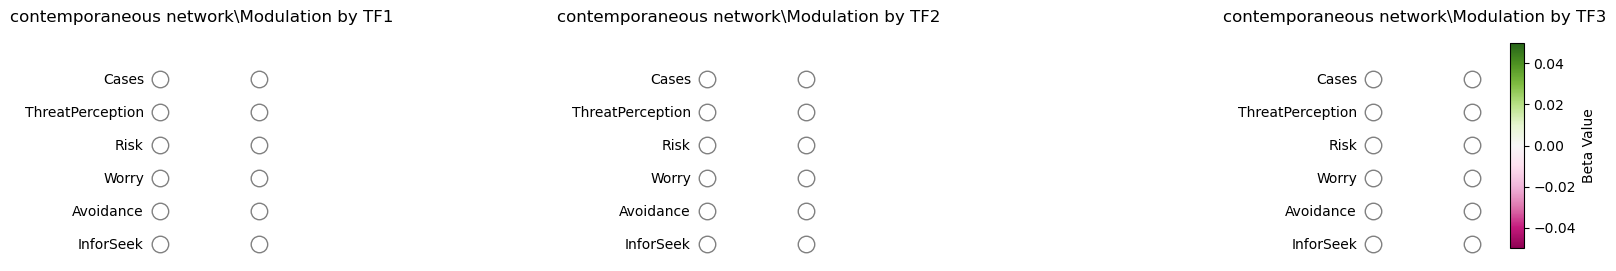

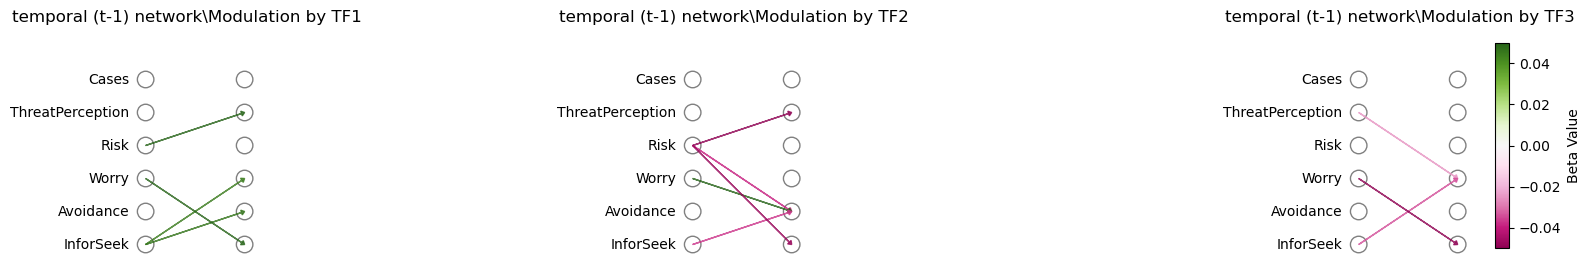

In [234]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    fig, ax = plt.subplots(1,3,figsize=(20, 3))
    for id_idx, id in enumerate(trait_factor_names_short):
        tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]=="lag0") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") , :]

        # Normalize beta values for the colormap, centered on 0 with symmetrical limits
        max_abs_beta = 0.05
        norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

        # Create a custom colormap
        cmap = plt.get_cmap('PiYG')

        vars_with_tfs = vars 

        var_to_id = {var: i for i, var in enumerate(vars_with_tfs)}
        # Create dv_id and iv_id columns
        tddf['dv_id'] = tddf['dv'].map(var_to_id)
        tddf['iv_id'] = tddf['iv'].map(var_to_id)

        # Grid settings
        n_vars = len(vars_with_tfs)
        circle_radius = 0.25
        arrow_scale = 0.5
        within_wave_dist = 3

        

        # Draw circles for previous and subsequent columns
        for i in range(n_vars):
            ax[id_idx].add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
            ax[id_idx].add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

        # Draw arrows within the continuous sequence
        for index, row in tddf.iterrows():
            dv_id = row['dv_id']
            iv_id = row['iv_id']
            beta = row['beta']
            color = cmap(norm(beta))
            ax[id_idx].arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

        # Add variable labels on the left
        for i, var in enumerate(vars_with_tfs):
            ax[id_idx].text(-0.5, i, var, verticalalignment='center', horizontalalignment='right')
        
        # Add title
        ax[id_idx].set_title(lbl+" network\Modulation by "+id)

        # Setting the limits and aspect ratio
        ax[id_idx].set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
        ax[id_idx].set_ylim(-0.5, n_vars + 0.5)
        ax[id_idx].set_aspect('equal')

        # Hide the axes
        ax[id_idx].axis('off')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax[2], orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')
    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs', 'paper_figures', 'timelag_plots', 'overall_netw_trait_modul_'+lag+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)

plt.show()


### Split by waves 

In [235]:
load_bywaves = 1
if load_bywaves==0:
    ddf = pd.DataFrame()
    for w in ['spring_wave', 'summer', 'autumn_wave']:
        fitdf2=fitdf.loc[fitdf["wave"]==w,:].dropna().join(df_id).reset_index()
        for dvidx, dv in enumerate(vars):
            
            ### Fit lag1 model first, record residuls ###
            dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")]) for tf in ["TF1", "TF2", "TF3"] ]
            
            eq = mm.generate_equation(dv+"_lag0",  ["session"]+dvs, [""], "reducedrank") 
            md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
            res = md.fit(method=['bfgs'])

            edf = res.conf_int(alpha=0.05)
            edf.columns = ["CI5", "CI95"]
            edf["beta"] = res.params
            edf["DF"] = res.df_resid
            edf["tval"] = res.tvalues
            edf["dv"] = dv 
            edf["wave"] = w
            edf["p"] = round(res.pvalues, 4)
            edf["eff_raw"] = edf.index
            edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
            edf["eff_time"] = edf["eff_raw"].apply(determine_lag_status)
            edf["indiff"] = edf.index.str.split(":").str[1]
            edf["iv"] = edf.index.str.split("_").str[0]

            fitdf2[dv+"_lag0_resid"] = res.resid
            ddf = pd.concat([ddf, edf.reset_index()])


            ### Fot contemporaneous model ###
            dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag0")]) for tf in ["TF1", "TF2", "TF3"] ]
            dvs = [i for i in dvs if dv+"_lag0" not in i]

            eq = mm.generate_equation(dv+"_lag0_resid",  ["session"]+dvs, [""], "reducedrank") 
            md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
            res = md.fit(method=['bfgs'])

            edf = res.conf_int(alpha=0.05)
            edf.columns = ["CI5", "CI95"]
            edf["beta"] = res.params
            edf["DF"] = res.df_resid
            edf["tval"] = res.tvalues
            edf["dv"] = dv 
            edf["wave"] = w
            edf["p"] = round(res.pvalues, 4)
            edf["eff_raw"] = edf.index
            edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
            edf["eff_time"] = edf["eff_raw"].apply(determine_lag_status)
            edf["indiff"] = edf.index.str.split(":").str[1]
            edf["iv"] = edf.index.str.split("_").str[0]

            ddf = pd.concat([ddf, edf.reset_index()])
    ddf.to_csv(os.path.join(root_dir, 'output', 'working_data', 'step_bywaves_model.csv'))
elif load_bywaves==1:
    ddf = pd.read_csv(os.path.join(root_dir, 'output', 'working_data', 'step_bywaves_model.csv'))
    

In [236]:
# Map variables to IDs
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)



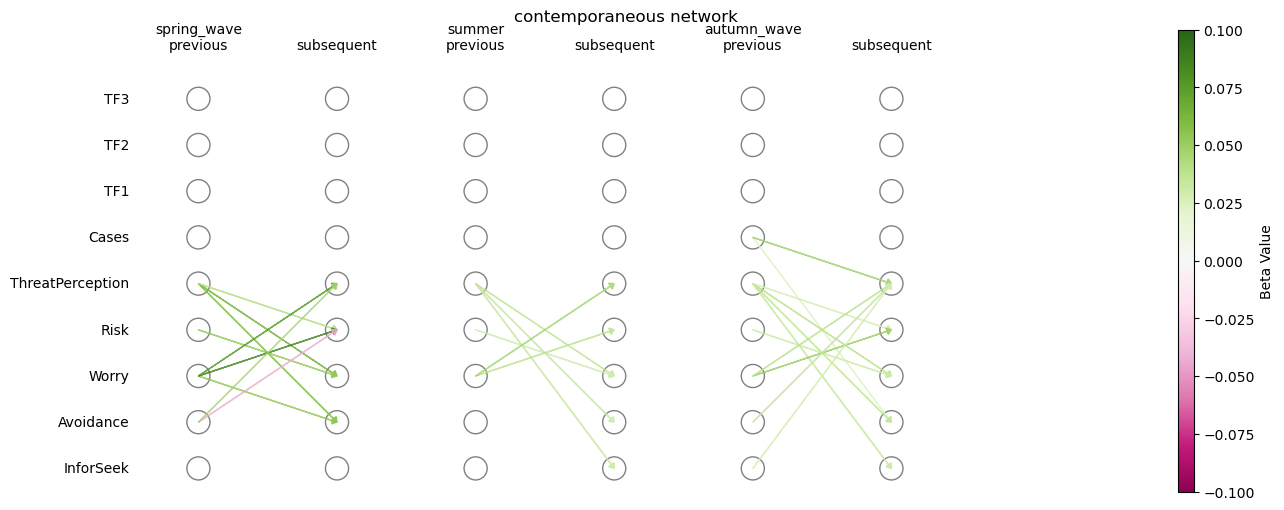

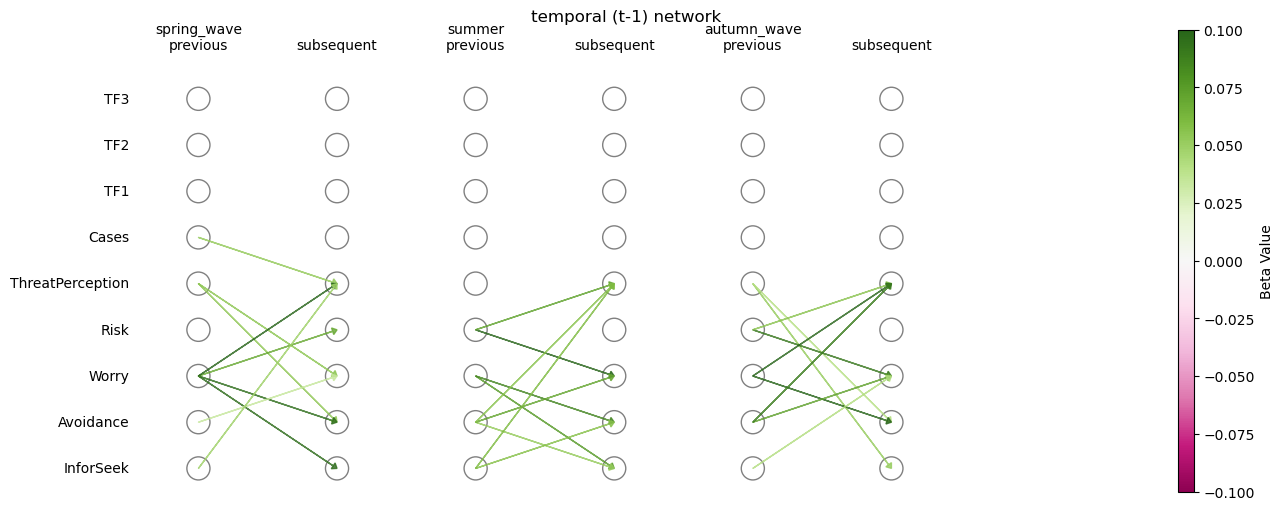

In [237]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    tddf = ddf.loc[(ddf["eff_type"] == "maineff") & (ddf["eff_time"]==lag) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    max_abs_beta = 0.1
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PiYG')

    vars_with_tfs = vars + trait_factor_names_short

    # Grid settings
    waves = ['spring_wave', 'summer', 'autumn_wave']
    n_waves = len(waves)
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 3

    # Adjust figure size for wider plot
    fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

    # Draw circles for previous and subsequent columns
    for w, wave in enumerate(waves):
        base_x = w * 6  # Increased gap between waves
        for i in range(n_vars):
            ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
            ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

    # Draw arrows within each wave
    for index, row in tddf.iterrows():
        wave_from = row['wave']
        w = waves.index(wave_from)
        base_x = w * 6
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half

    # Add wave names and column labels
    for w, wave in enumerate(waves):
        base_x = w * 6
        ax.text(base_x, n_vars, wave + "\nprevious", horizontalalignment='center', verticalalignment='bottom')
        ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')
    ax.set_title(lbl+ " network")

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    plt.show()

In [238]:
ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]=="lag1"),]

Unnamed: 0                      index       CI5      CI95      beta  \
4             4             Cases_lag1:TF1 -0.033775  0.106201  0.036213   
6             6             Cases_lag1:TF2 -0.073606  0.029815 -0.021895   
8             8             Cases_lag1:TF3 -0.083204  0.035394 -0.023905   
10           10  ThreatPerception_lag1:TF1 -0.076297  0.088124  0.005913   
11           11  ThreatPerception_lag1:TF2 -0.068638  0.053390 -0.007624   
12           12  ThreatPerception_lag1:TF3 -0.072820  0.067332 -0.002744   
14           14              Risk_lag1:TF1 -0.156684  0.037973 -0.059356   
15           15              Risk_lag1:TF2 -0.084614  0.053279 -0.015667   
16           16              Risk_lag1:TF3 -0.040735  0.124699  0.041982   
18           18             Worry_lag1:TF1 -0.070570  0.141299  0.035364   
19           19             Worry_lag1:TF2 -0.082482  0.077015 -0.002733   
20           20             Worry_lag1:TF3 -0.120356  0.061999 -0.029179   
22           22         Avoidance_lag1:TF1 -0.075735  0.100782  0.012524   
23           23         Avoidance_lag1:TF2 -0.061742  0.080775  0.009517   
24           24         Avoidance_lag1:TF3 -0.036848  0.124862  0.044007   
26           26         InforSeek_lag1:TF1 -0.014080  0.141915  0.063918   
27           27         InforSeek_lag1:TF2 -0.055841  0.061795  0.002977   
28           28         InforSeek_lag1:TF3 -0.173610 -0.033532 -0.103571   
60            4             Cases_lag1:TF1 -0.062111  0.048204 -0.006954   
62            6             Cases_lag1:TF2 -0.030486  0.053733  0.011623   
64            8             Cases_lag1:TF3 -0.050185  0.043253 -0.003466   
66           10  ThreatPerception_lag1:TF1 -0.036974  0.092634  0.027830   
67           11  ThreatPerception_lag1:TF2 -0.045900  0.050391  0.002245   
68           12  ThreatPerception_lag1:TF3 -0.068906  0.041516 -0.013695   
70           14              Risk_lag1:TF1 -0.061108  0.068345  0.003619   
71           15              Risk_lag1:TF2 -0.074352  0.016564 -0.028894   
72           16              Risk_lag1:TF3 -0.010949  0.099130  0.044091   
74           18             Worry_lag1:TF1 -0.112601  0.030718 -0.040941   
75           19             Worry_lag1:TF2 -0.036502  0.079261  0.021379   
76           20             Worry_lag1:TF3 -0.058285  0.066682  0.004199   
78           22         Avoidance_lag1:TF1 -0.031426  0.085620  0.027097   
79           23         Avoidance_lag1:TF2 -0.037368  0.063432  0.013032   
80           24         Avoidance_lag1:TF3 -0.107131  0.001710 -0.052711   
82           26         InforSeek_lag1:TF1 -0.012470  0.095927  0.041728   
83           27         InforSeek_lag1:TF2 -0.058711  0.020515 -0.019098   
84           28         InforSeek_lag1:TF3 -0.083176  0.020459 -0.031359   
116           4             Cases_lag1:TF1 -0.086998  0.012688 -0.037155   
118           6             Cases_lag1:TF2 -0.031435  0.044685  0.006625   
120           8             Cases_lag1:TF3 -0.039714  0.045857  0.003072   
122          10  ThreatPerception_lag1:TF1  0.003717  0.122066  0.062892   
123          11  ThreatPerception_lag1:TF2 -0.013934  0.065265  0.025666   
124          12  ThreatPerception_lag1:TF3 -0.123705 -0.030580 -0.077142   
126          14              Risk_lag1:TF1 -0.058092  0.063930  0.002919   
127          15              Risk_lag1:TF2 -0.058158  0.027755 -0.015201   
128          16              Risk_lag1:TF3 -0.031836  0.071797  0.019981   
130          18             Worry_lag1:TF1 -0.108177  0.016401 -0.045888   
131          19             Worry_lag1:TF2 -0.076686  0.028146 -0.024270   
132          20             Worry_lag1:TF3 -0.052502  0.065196  0.006347   
134          22         Avoidance_lag1:TF1 -0.050950  0.058448  0.003749   
135          23         Avoidance_lag1:TF2 -0.021312  0.070690  0.024689   
136          24         Avoidance_lag1:TF3 -0.069842  0.028549 -0.020647   
138          26         InforSeek_lag1:TF1 -0.060249 

### plot modulation by TFs by wave 

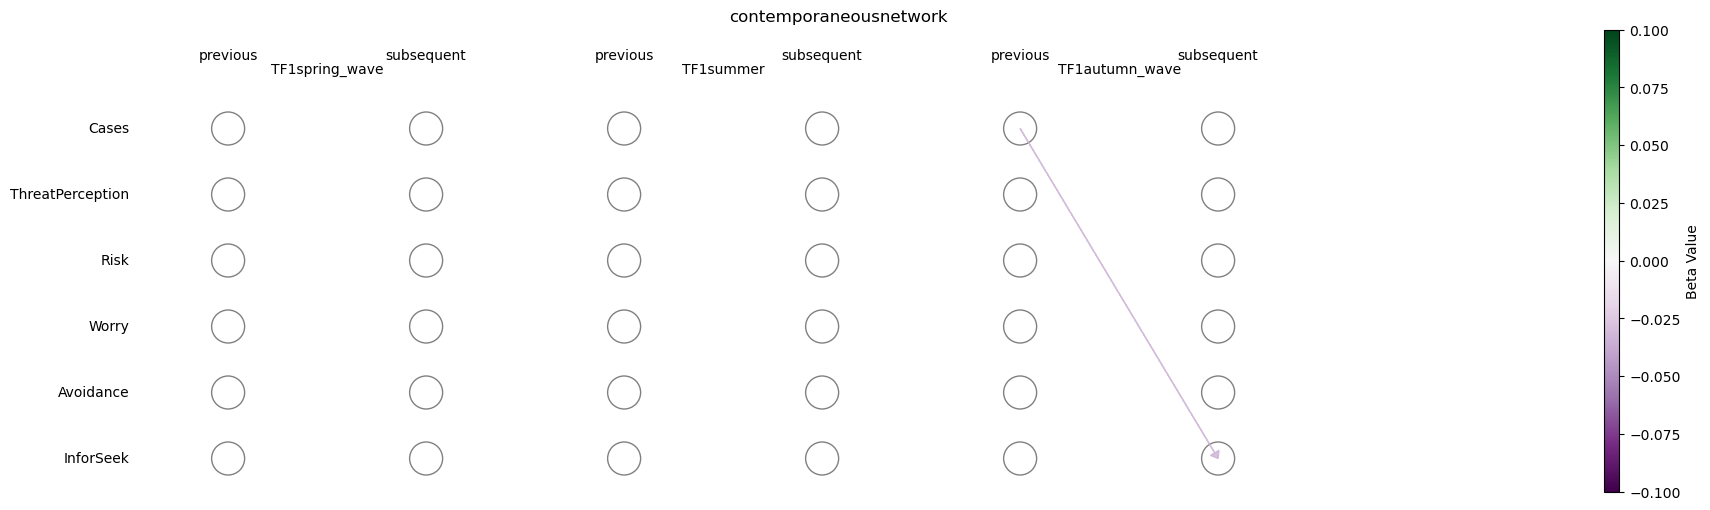

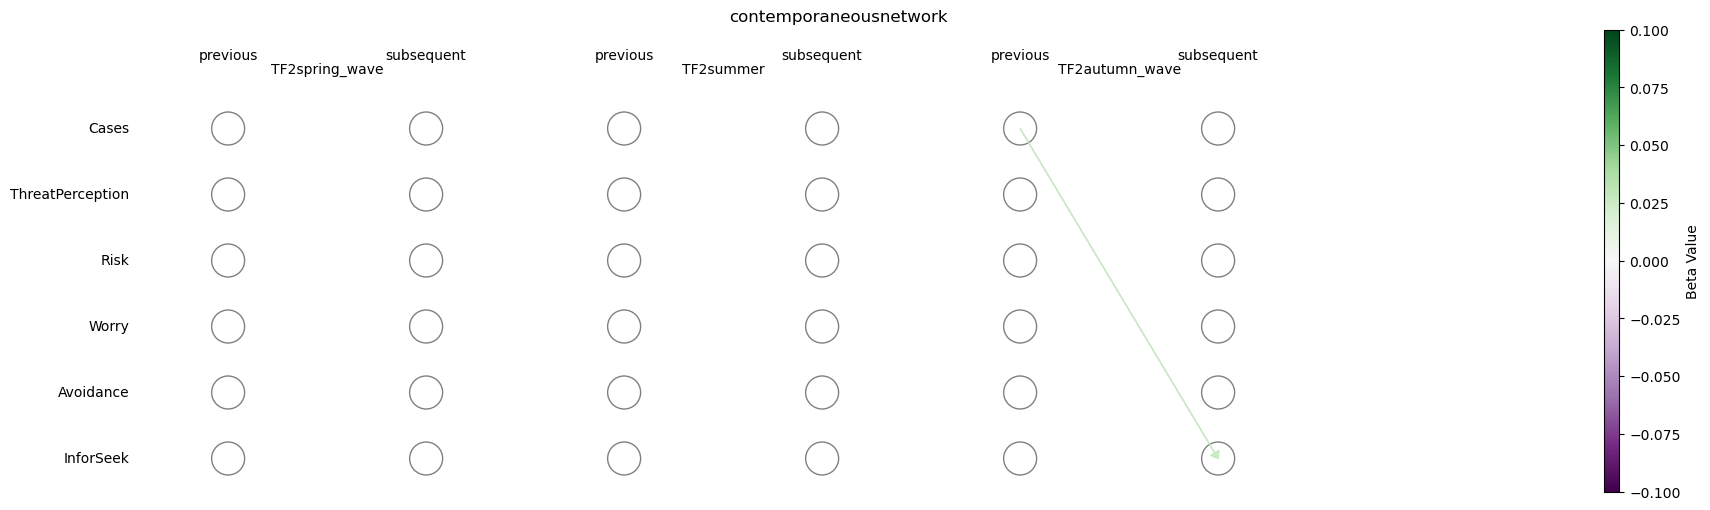

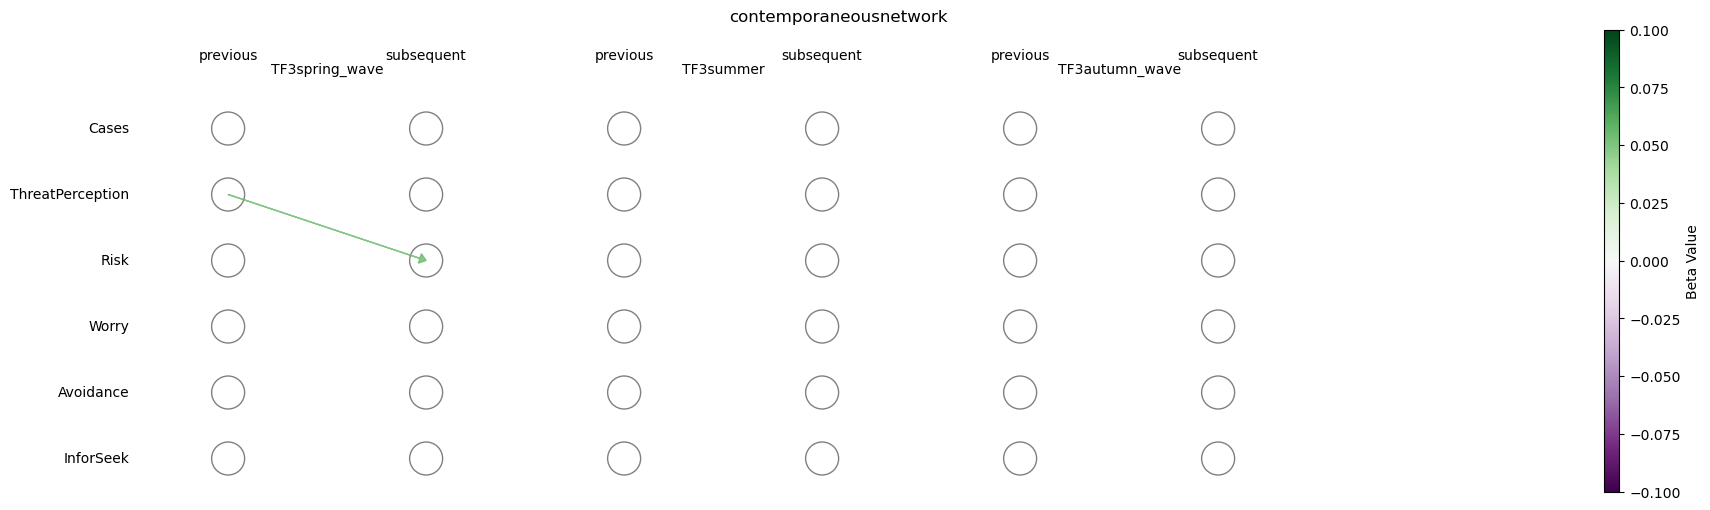

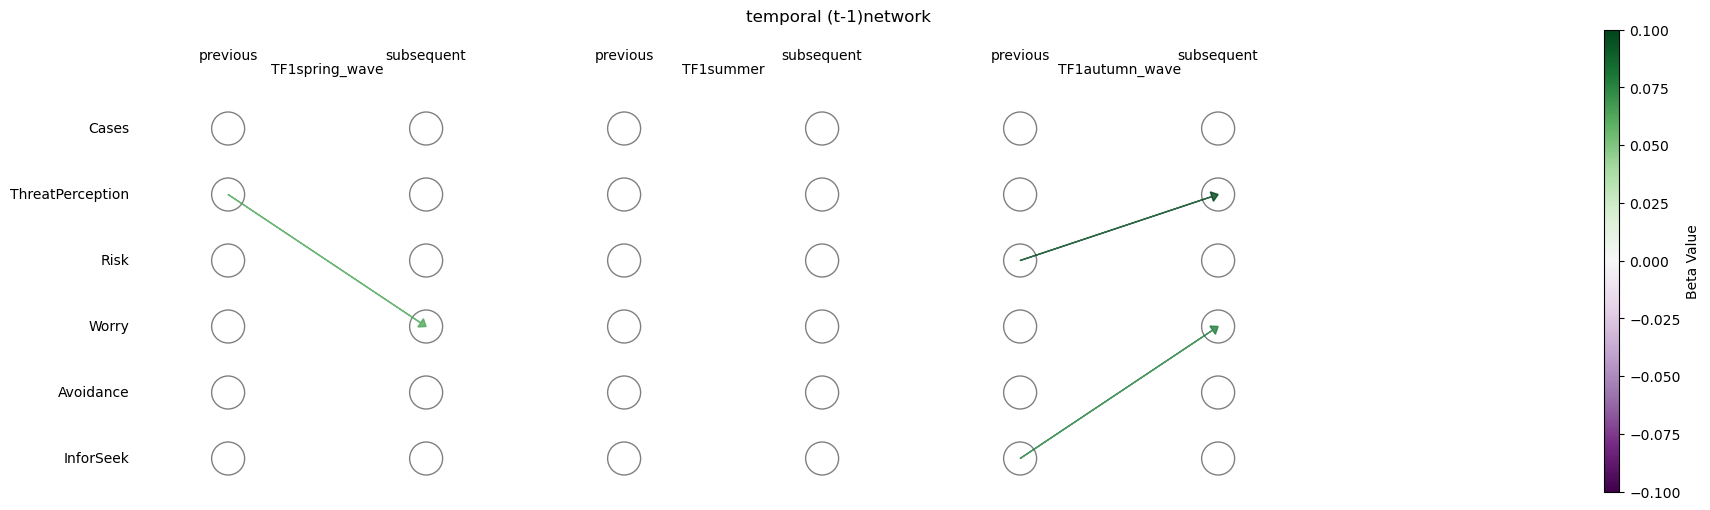

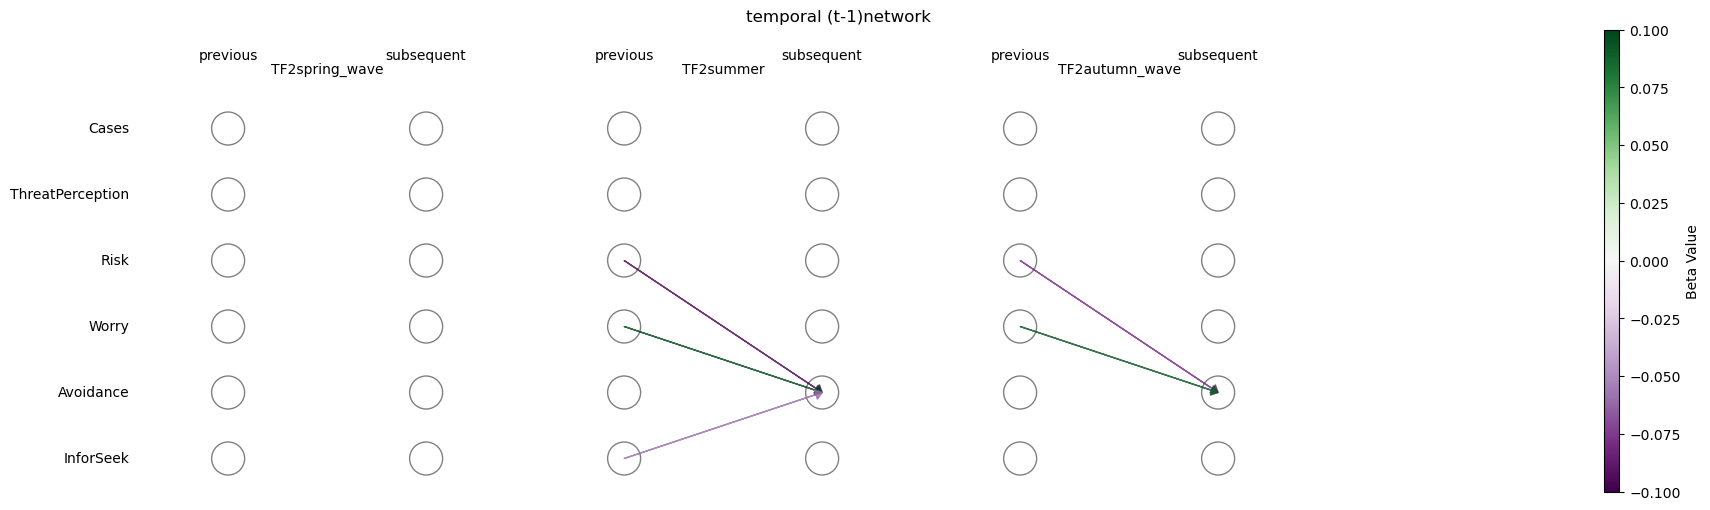

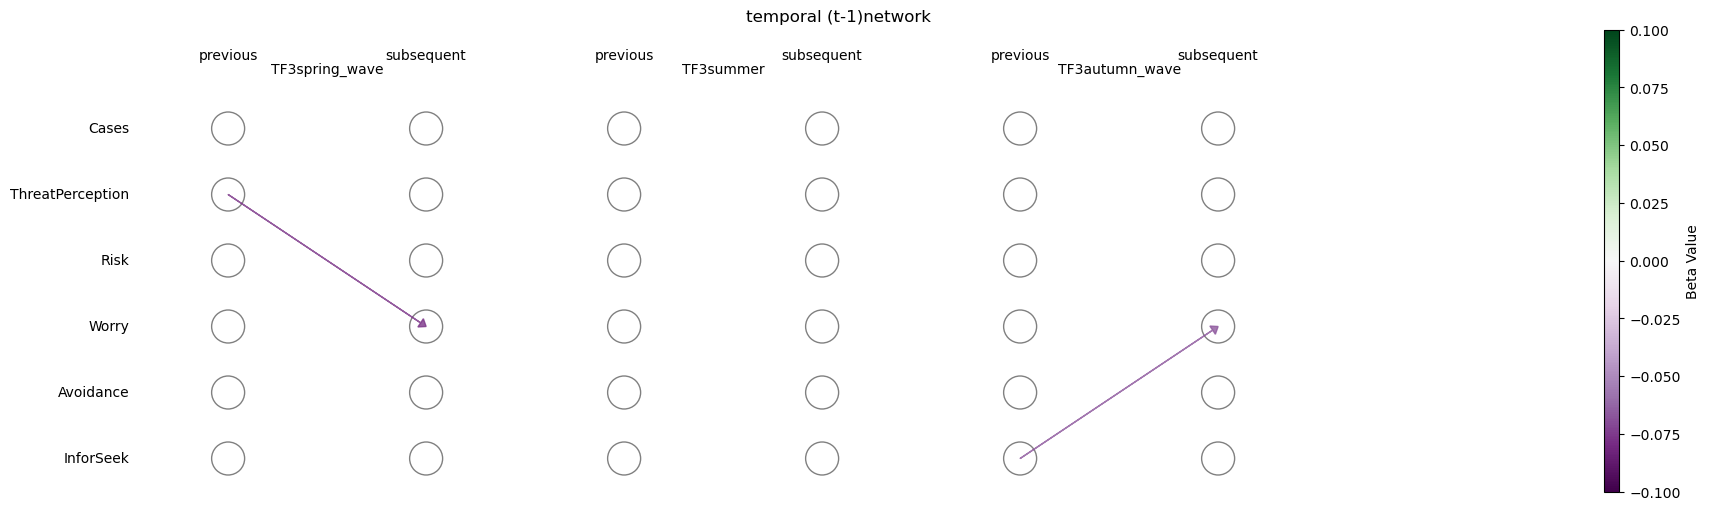

In [239]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    for id in trait_factor_names_short:
        tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") , :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

        # Normalize beta values for the colormap, centered on 0 with symmetrical limits
        # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
        max_abs_beta = 0.1
        norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

        # Create a custom colormap
        cmap = plt.get_cmap('PRGn')

        vars_with_tfs = vars 

        # Grid settings
        waves = ['spring_wave', 'summer', 'autumn_wave']
        n_waves = len(waves)
        n_vars = len(vars_with_tfs)
        circle_radius = 0.25
        arrow_scale = 0.5
        within_wave_dist = 3

        # Adjust figure size for wider plot
        fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

        # Draw circles for previous and subsequent columns
        for w, wave in enumerate(waves):
            base_x = w * 6  # Increased gap between waves
            for i in range(n_vars):
                ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
                ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

        # Draw arrows within each wave
        for index, row in tddf.iterrows():
            wave_from = row['wave']
            w = waves.index(wave_from)
            base_x = w * 6
            dv_id = row['dv_id']
            iv_id = row['iv_id']
            beta = row['beta']
            color = cmap(norm(beta))
            ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

        # Add variable labels on the left
        for i, var in enumerate(vars_with_tfs):
            ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half
        


        # Add wave names and column labels
        for w, wave in enumerate(waves):
            base_x = w * 6
            ax.text(base_x+within_wave_dist/2, n_vars, id+wave , horizontalalignment='center', verticalalignment='top')
            ax.text(base_x, n_vars, "previous", horizontalalignment='center', verticalalignment='bottom')
            ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

        # Setting the limits and aspect ratio
        ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
        ax.set_ylim(-0.5, n_vars + 0.5)
        ax.set_aspect('equal')
        ax.set_title(lbl+ "network")

        # Hide the axes
        ax.axis('off')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Add colorbar with adjusted size and position
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
        cbar.set_label('Beta Value')

        plt.show()